# NCAA ML Competition - Women's 2018

## Notes

Notes about what's in the data files: https://www.kaggle.com/c/womens-machine-learning-competition-2018/data

Starter Kernel might help: https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-women-s-dataset

In [1176]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import tree 

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report


## Load Data

In [1177]:
# Load the data
data_dir = './WStage2DataFiles/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tour_compact = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')
df_tour_detail = pd.read_csv(data_dir + 'WNCAATourneyDetailedResults.csv')
df_reg_compact = pd.read_csv(data_dir + 'WRegularSeasonCompactResults.csv')
df_reg_detail = pd.read_csv(data_dir + 'WRegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(data_dir + 'WTeams.csv')
df_teams_leagues = pd.merge(left=df_teams, right=pd.read_csv(data_dir + 'WLeagues.csv'), how='left', on=['TeamName'])


### Get Matchups of interest for Training & Test Data

In [1178]:
## Get 2018 data

# sorting ensures that we work through smallest to largest 
# no repeats, smallest always first in pair
current_year = df_seeds[df_seeds['Season'] == 2018].sort_values(by=['TeamID'])
current_year_pairs = list(it.combinations(current_year['TeamID'],2))

team1, team2 = map(list, zip(*current_year_pairs))

df_test_pairs = pd.DataFrame({
    'Season' : [2018] * len(team1),
    'Team1' : team1,
    'Team2' : team2
})

In [1179]:
# this gives us test pairings! Season, Team1, Team2
df_test_pairs.head()

,Season,Team1,Team2
0,2018,3110,3113
1,2018,3110,3114
2,2018,3110,3124
3,2018,3110,3125
4,2018,3110,3129


In [1180]:
# also need previous matchups (1998 - 2017)
df_train_pairs = pd.DataFrame(
    { 'Team1' : df_tour_compact['WTeamID'],
     'Team2' : df_tour_compact['LTeamID'],
     'Season' : df_tour_compact['Season']
    })

df_train_pairs.tail()

,Season,Team1,Team2
1255,2017,3163,3332
1256,2017,3376,3199
1257,2017,3280,3163
1258,2017,3376,3390
1259,2017,3376,3280


In [1181]:
# this is what we will use as a base to build our dataset
df_train_test_matchups = df_train_pairs.append(df_test_pairs)

In [1182]:
# determine history of tournament we want to include
hist = 2

## Feature Engineering for Training & Test Data

### Current Year Seeds

In [1183]:
# get just integer value of seed (exclude region information)
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['SeedInt'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [1184]:
# merge seeds with team IDs for tourney performance
df_W = df_seeds.rename(columns={'TeamID':'Team1', 'SeedInt':'Team1Seed'})
df_L = df_seeds.rename(columns={'TeamID':'Team2', 'SeedInt':'Team2Seed'})
df_dummy = pd.merge(left=df_train_test_matchups, right=df_W, how='left', on=['Season', 'Team1'])
df_matchups = pd.merge(left=df_dummy, right=df_L, how='left', on=['Season', 'Team2'])

df_matchups.tail()

,Season,Team1,Team2,Team1Seed,Team2Seed
3271,2018,3437,3443,9,11
3272,2018,3437,3453,9,7
3273,2018,3438,3443,10,11
3274,2018,3438,3453,10,7
3275,2018,3443,3453,11,7


### Current Year Seed Difference

In [1185]:
# negative number indicates that team 2 (loser, in this case) has higher seed
df_matchups['SeedDiff'] = df_matchups['Team2Seed']
df_matchups['SeedDiff'] = df_matchups['Team2Seed'].sub(df_matchups['Team1Seed'], axis=0)

df_matchups.tail()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff
3271,2018,3437,3443,9,11,2
3272,2018,3437,3453,9,7,-2
3273,2018,3438,3443,10,11,1
3274,2018,3438,3453,10,7,-3
3275,2018,3443,3453,11,7,-4


### Last Year's Tournament Seed 

In [1186]:
# what to do for games where we had no previous year (1998)?

# add 1 so easily referenced
df_seeds = df_seeds.rename(columns={'Season' : 'CurrSeason'})
df_seeds['Season'] = df_seeds['CurrSeason'].apply(lambda x: x + 1)


In [1187]:
df_W = df_seeds.rename(columns={'TeamID':'Team1','SeedInt':'Team1PrevSeed'})
df_L = df_seeds.rename(columns={'TeamID':'Team2','SeedInt':'Team2PrevSeed'})
df_dummy = pd.merge(left=df_matchups, right=df_W, how='left', on=['Season', 'Team1'])
df_matchups = pd.merge(left=df_dummy, right=df_L, how='left', on=['Season', 'Team2']).drop(labels=['CurrSeason_x','CurrSeason_y'],axis=1)

## what to do if they weren't in the tournament last year (17?)
df_matchups = df_matchups.fillna(value=17)

df_matchups.tail()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed
3271,2018,3437,3443,9,11,2,17.0,12.0
3272,2018,3437,3453,9,7,-2,17.0,8.0
3273,2018,3438,3443,10,11,1,17.0,12.0
3274,2018,3438,3453,10,7,-3,17.0,8.0
3275,2018,3443,3453,11,7,-4,12.0,8.0


In [1188]:
df_seeds.drop(labels=['Season'],axis=1,inplace=True)
df_seeds = df_seeds.rename(columns={'CurrSeason' : 'Season'})

In [1189]:
df_seeds.tail()

,Season,TeamID,SeedInt
1339,2018,3195,12
1340,2018,3211,13
1341,2018,3251,14
1342,2018,3212,15
1343,2018,3129,16


### Average Tournament Seed Over Past X Years

In [1190]:
w_seed_hist = []
l_seed_hist = []

w_game_hist = []
l_game_hist = []

# for each one, get past X years of tourney seeds
for i,r in df_matchups.iterrows():
    w_team_apps =  df_seeds[(df_seeds['TeamID'] == r['Team1'])] #all apps
    # recent appearances
    w_team_recent_apps = w_team_apps[(w_team_apps['Season'] >= (r['Season'] - hist)) & (w_team_apps['Season'] < r['Season'])]
    
    w_wins = df_matchups[(df_matchups['Team1'] == r['Team1'])]
    w_recent_wins = w_wins[(w_wins['Season'] >= (r['Season'] - hist)) & (w_wins['Season'] < r['Season'])]

    # take into account years they weren't in the tournament, penalizes for that (approx. seed = 17)
    w_avg_seed = (w_team_recent_apps['SeedInt'].sum() + (((hist) - len(w_team_recent_apps)) * 17)) / float(hist)
    
    # not making it recently is same as making it and losing 
    if len(w_team_recent_apps) == 0:
        w_avg_games = 0
    else:
        w_avg_games = (len(w_recent_wins)) / float(len(w_team_recent_apps))

    w_game_hist.append(round(w_avg_games,2))
    w_seed_hist.append(round(w_avg_seed,2))
    
    l_team_apps =  df_seeds[(df_seeds['TeamID'] == r['Team2'])]
    l_team_recent_apps = l_team_apps[(l_team_apps['Season'] >= (r['Season'] - hist)) & (l_team_apps['Season'] < r['Season'])]
    
    l_wins = df_matchups[(df_matchups['Team1'] == r['Team2'])]
    l_recent_wins = l_wins[(l_wins['Season'] >= (r['Season'] - hist)) & (l_wins['Season'] < r['Season'])]

    # take into account years they weren't in the tournament, penalizes for that (approx. seed = 17)
    l_avg_seed = (l_team_recent_apps['SeedInt'].sum() + (((hist) - len(l_team_recent_apps)) * 17)) / float(hist)
    if len(l_team_recent_apps) == 0:
        l_avg_games = 0
    else:
        l_avg_games = (len(l_recent_wins)) / float(len(l_team_recent_apps))
    
    l_game_hist.append(round(l_avg_games,2))
    l_seed_hist.append(round(l_avg_seed,2))


df_matchups['Team1AvgSeed'] = w_seed_hist
df_matchups['Team2AvgSeed'] = l_seed_hist
df_matchups['Team1AvgGames'] = w_game_hist
df_matchups['Team2AvgGames'] = l_game_hist

# for now, inspect the tail 
df_matchups.tail(10)

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1AvgSeed,Team2AvgSeed,Team1AvgGames,Team2AvgGames
3266,2018,3417,3437,3,9,6,4.0,17.0,3.5,17.0,2.0,0.0
3267,2018,3417,3438,3,10,7,4.0,17.0,3.5,17.0,2.0,0.0
3268,2018,3417,3443,3,11,8,4.0,12.0,3.5,14.5,2.0,0.0
3269,2018,3417,3453,3,7,4,4.0,8.0,3.5,9.0,2.0,0.0
3270,2018,3437,3438,9,10,1,17.0,17.0,17.0,17.0,0.0,0.0
3271,2018,3437,3443,9,11,2,17.0,12.0,17.0,14.5,0.0,0.0
3272,2018,3437,3453,9,7,-2,17.0,8.0,17.0,9.0,0.0,0.0
3273,2018,3438,3443,10,11,1,17.0,12.0,17.0,14.5,0.0,0.0
3274,2018,3438,3453,10,7,-3,17.0,8.0,17.0,9.0,0.0,0.0
3275,2018,3443,3453,11,7,-4,12.0,8.0,14.5,9.0,0.0,0.0


### Last Year's Tournament Performance 

#### For now, this will be number of games won

### Average Tournament Performance Over Past 5 Years

### League Competitiveness

In [1191]:
df_tour_hist = df_matchups
df_tour_hist.head()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1AvgSeed,Team2AvgSeed,Team1AvgGames,Team2AvgGames
0,1998,3104,3422,2,15,13,17.0,17.0,17.0,17.0,0.0,0.0
1,1998,3112,3365,3,14,11,17.0,17.0,17.0,17.0,0.0,0.0
2,1998,3163,3193,2,15,13,17.0,17.0,17.0,17.0,0.0,0.0
3,1998,3198,3266,7,10,3,17.0,17.0,17.0,17.0,0.0,0.0
4,1998,3203,3208,10,7,-3,17.0,17.0,17.0,17.0,0.0,0.0


In [1192]:
df_tour_hist.tail()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1AvgSeed,Team2AvgSeed,Team1AvgGames,Team2AvgGames
3271,2018,3437,3443,9,11,2,17.0,12.0,17.0,14.5,0.0,0.0
3272,2018,3437,3453,9,7,-2,17.0,8.0,17.0,9.0,0.0,0.0
3273,2018,3438,3443,10,11,1,17.0,12.0,17.0,14.5,0.0,0.0
3274,2018,3438,3453,10,7,-3,17.0,8.0,17.0,9.0,0.0,0.0
3275,2018,3443,3453,11,7,-4,12.0,8.0,14.5,9.0,0.0,0.0


In [1193]:
apps = df_seeds[df_seeds['Season'] < 2018].groupby('TeamID').count()
apps.head(10)

,Season,SeedInt
TeamID,,
3103,1,1
3104,2,2
3106,3,3
3107,6,6
3108,3,3
3110,1,1
3111,1,1
3112,6,6
3113,12,12


In [1194]:
# number of times they've been team 1 = wins
games = df_tour_hist[df_tour_hist['Season'] < 2018].groupby('Team1').count()
games.head()
#.count().reset_index()[['Team1','Season']].rename(columns={'Season':'WWins'})

,Season,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1AvgSeed,Team2AvgSeed,Team1AvgGames,Team2AvgGames
Team1,,,,,,,,,,,
3104,3,3,3,3,3,3,3,3,3,3,3
3107,1,1,1,1,1,1,1,1,1,1,1
3112,5,5,5,5,5,5,5,5,5,5,5
3113,16,16,16,16,16,16,16,16,16,16,16
3114,2,2,2,2,2,2,2,2,2,2,2


In [1195]:
#
winning_games_w = df_tour_hist.groupby('Team1').count().reset_index()[['Team1','Season']].rename(columns={'Season':'WWins'})
winning_games_l = df_tour_hist.groupby('Team1').count().reset_index()[['Team1','Season']].rename(columns={'Season':'LWins','Team1':'Team2'})

losing_games_w = df_tour_hist.groupby('Team2').count().reset_index()[['Team2','Season']].rename(columns={'Season':'WLosses','Team2':'Team1'})
losing_games_l = df_tour_hist.groupby('Team2').count().reset_index()[['Team2','Season']].rename(columns={'Season':'LLosses'})

# get total tournament games - all games, could be more than 1 appearance per year
df_total_apps = pd.merge(left=df_tour_hist, right=winning_games_w, how='left', on=['Team1']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=winning_games_l, how='left', on=['Team2']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=losing_games_w, how='left', on=['Team1']).fillna(0)
df_total_apps = pd.merge(left=df_total_apps, right=losing_games_l, how='left', on=['Team2']).fillna(0)


df_total_apps['WTotGames'] = df_total_apps['WWins'] + df_total_apps['WLosses']
df_total_apps['WPctWins'] = df_total_apps['WWins'] / df_total_apps['WTotGames'] 

df_total_apps['LTotGames'] = df_total_apps['LWins'] + df_total_apps['LLosses']
df_total_apps['LPctWins'] = df_total_apps['LWins'] / df_total_apps['LTotGames'] 

# This now includes: 
df_total_apps.head()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1AvgSeed,Team2AvgSeed,Team1AvgGames,Team2AvgGames,WWins,LWins,WLosses,LLosses,WTotGames,WPctWins,LTotGames,LPctWins
0,1998,3104,3422,2,15,13,17.0,17.0,17.0,17.0,0.0,0.0,3,0.0,2,1,5,0.600000,1.0,0.000000
1,1998,3112,3365,3,14,11,17.0,17.0,17.0,17.0,0.0,0.0,5,0.0,6,4,11,0.454545,4.0,0.000000
2,1998,3163,3193,2,15,13,17.0,17.0,17.0,17.0,0.0,0.0,147,0.0,19,2,166,0.885542,2.0,0.000000
3,1998,3198,3266,7,10,3,17.0,17.0,17.0,17.0,0.0,0.0,2,38.0,3,35,5,0.400000,73.0,0.520548
4,1998,3203,3208,10,7,-3,17.0,17.0,17.0,17.0,0.0,0.0,53,70.0,30,38,83,0.638554,108.0,0.648148


In [1196]:
# determine 'competitiveness of league' 
## What teams have good win percentages
df_win_apps = df_total_apps.rename(columns={'WPctWins' : 'PctWins','Team1' : 'TeamID', 'WTotGames': 'TotGames'})
df_loss_apps = df_total_apps.rename(columns={'LPctWins' : 'PctWins', 'Team2' : 'TeamID', 'LTotGames': 'TotGames'})

df_apps = df_win_apps[['PctWins','TeamID','TotGames']].append(df_loss_apps[['PctWins','TeamID','TotGames']])
df_apps = df_apps.drop_duplicates()

## This means that a lot of these have never been to the tournament - makes sense
#plt.hist(df_apps['PctWins'],bins=10)

# Maybe need to filter for just teams that are currently in tourney
#l = df_seeds.loc[df_seeds['Season'] == 2018]
#plt.hist((df_apps[df_apps['TeamID'].isin(l['TeamID'])])['PctWins'],bins=10)

In [1197]:
df_teams_leagues.head()

,TeamID,TeamName,LeagueName
0,3101,Abilene Chr,Southland
1,3102,Air Force,MWC
2,3103,Akron,MAC
3,3104,Alabama,SEC
4,3105,Alabama A&M,SWAC


In [1198]:
# Merge Performance Stats with league info
df_league_pct = pd.merge(left=df_apps, right = df_teams_leagues, how='left', on=['TeamID'])

# group by league to see how leagues perform
df_league_perf = df_league_pct.groupby('LeagueName')['PctWins'].mean().reset_index()

df_league_perf.head()

,LeagueName,PctWins
0,AAC,0.227926
1,ACC,0.501126
2,ASUN,0.172794
3,America East,0.237395
4,Atlantic 10,0.323755


In [1199]:
df_teams_leagues = pd.merge(left=df_teams_leagues,right = df_league_perf, how='left', on=['LeagueName'])

In [1200]:
df_teams_leagues.head()

,TeamID,TeamName,LeagueName,PctWins
0,3101,Abilene Chr,Southland,0.084656
1,3102,Air Force,MWC,0.299423
2,3103,Akron,MAC,0.231940
3,3104,Alabama,SEC,0.507880
4,3105,Alabama A&M,SWAC,0.090110


In [1201]:
df_W = df_teams_leagues[['TeamID','PctWins']].rename(columns={'TeamID':'Team1', 'PctWins' : "Team1LeaguePerf"})
df_L = df_teams_leagues[['TeamID','PctWins']].rename(columns={'TeamID':'Team2', 'PctWins' : "Team2LeaguePerf"})


In [1202]:
df_dummy = pd.merge(left=df_matchups, right=df_W, how='left', on=['Team1'])
df_matchups = pd.merge(left=df_dummy, right=df_L, how='left', on=['Team2'])

df_matchups.tail()

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1AvgSeed,Team2AvgSeed,Team1AvgGames,Team2AvgGames,Team1LeaguePerf,Team2LeaguePerf
3271,2018,3437,3443,9,11,2,17.0,12.0,17.0,14.5,0.0,0.0,0.454189,0.282576
3272,2018,3437,3453,9,7,-2,17.0,8.0,17.0,9.0,0.0,0.0,0.454189,0.067320
3273,2018,3438,3443,10,11,1,17.0,12.0,17.0,14.5,0.0,0.0,0.501126,0.282576
3274,2018,3438,3453,10,7,-3,17.0,8.0,17.0,9.0,0.0,0.0,0.501126,0.067320
3275,2018,3443,3453,11,7,-4,12.0,8.0,14.5,9.0,0.0,0.0,0.282576,0.067320


In [1203]:
df_matchups['LeaguePerfDiff'] = df_matchups['Team1LeaguePerf'] - df_matchups['Team2LeaguePerf']

In [1204]:
df_matchups.tail(10)

,Season,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1AvgSeed,Team2AvgSeed,Team1AvgGames,Team2AvgGames,Team1LeaguePerf,Team2LeaguePerf,LeaguePerfDiff
3266,2018,3417,3437,3,9,6,4.0,17.0,3.5,17.0,2.0,0.0,0.487518,0.454189,0.033329
3267,2018,3417,3438,3,10,7,4.0,17.0,3.5,17.0,2.0,0.0,0.487518,0.501126,-0.013608
3268,2018,3417,3443,3,11,8,4.0,12.0,3.5,14.5,2.0,0.0,0.487518,0.282576,0.204942
3269,2018,3417,3453,3,7,4,4.0,8.0,3.5,9.0,2.0,0.0,0.487518,0.067320,0.420198
3270,2018,3437,3438,9,10,1,17.0,17.0,17.0,17.0,0.0,0.0,0.454189,0.501126,-0.046937
3271,2018,3437,3443,9,11,2,17.0,12.0,17.0,14.5,0.0,0.0,0.454189,0.282576,0.171613
3272,2018,3437,3453,9,7,-2,17.0,8.0,17.0,9.0,0.0,0.0,0.454189,0.067320,0.386869
3273,2018,3438,3443,10,11,1,17.0,12.0,17.0,14.5,0.0,0.0,0.501126,0.282576,0.218550
3274,2018,3438,3453,10,7,-3,17.0,8.0,17.0,9.0,0.0,0.0,0.501126,0.067320,0.433806
3275,2018,3443,3453,11,7,-4,12.0,8.0,14.5,9.0,0.0,0.0,0.282576,0.067320,0.215255


### LAST: Generate negative examples + Split into training (train + dev) and test

In [1205]:
df_matchups = df_matchups[(df_matchups['Season'] >= (1998 + hist)) & (df_matchups['Season'] < 2018)]

# test data only
x_test = df_matchups[df_matchups['Season'] == 2018]

In [1206]:
## Remove Season - what happens
df_matchups_2 = df_matchups.drop(labels=['Season'], axis=1)

x_test_2 = x_test.drop(labels=['Season'], axis=1)

In [1207]:
df_matchups_2.tail()

,Team1,Team2,Team1Seed,Team2Seed,SeedDiff,Team1PrevSeed,Team2PrevSeed,Team1AvgSeed,Team2AvgSeed,Team1AvgGames,Team2AvgGames,Team1LeaguePerf,Team2LeaguePerf,LeaguePerfDiff
1255,3163,3332,1,10,9,1.0,17.0,1.0,17.0,6.0,0.0,0.227926,0.487518,-0.259593
1256,3376,3199,1,3,2,1.0,5.0,1.0,3.5,3.0,2.5,0.507880,0.501126,0.006753
1257,3280,3163,2,1,-1,5.0,1.0,5.0,1.0,1.5,6.0,0.507880,0.227926,0.279954
1258,3376,3390,1,2,1,1.0,4.0,1.0,4.0,3.0,2.5,0.507880,0.487518,0.020362
1259,3376,3280,1,2,1,1.0,5.0,1.0,5.0,3.0,1.5,0.507880,0.507880,0.000000


In [1208]:
# Generate negative examples
df_neg = pd.DataFrame(
{
    'Season' : df_matchups['Season']  ,
    'SeedDiff' : -df_matchups['SeedDiff'],
    'Team1' : df_matchups['Team2']  ,
    'Team1Seed' : df_matchups['Team2Seed']  ,
    'Team1PrevSeed' : df_matchups['Team2PrevSeed']  ,
    'Team1LeaguePerf' : df_matchups['Team2LeaguePerf']  ,
    'Team2' : df_matchups['Team1']  ,
    'Team2Seed' : df_matchups['Team1Seed']  ,
    'Team2PrevSeed' : df_matchups['Team1PrevSeed']  ,
    'Team2LeaguePerf' : df_matchups['Team1LeaguePerf']  ,
    'LeaguePerfDiff' : - df_matchups['LeaguePerfDiff'] ,
    'Team1AvgSeed' : df_matchups['Team2AvgSeed'] ,
    'Team2AvgSeed' : df_matchups['Team1AvgSeed'] ,
    'Team1AvgGames' : df_matchups['Team2AvgGames'] ,
    'Team2AvgGames' : df_matchups['Team1AvgGames']

})

In [1209]:
# include positive and negative examples from 1999 - 2017 (for now)
x_train = df_matchups.append(df_neg)

In [1210]:
x_train.head()

,LeaguePerfDiff,Season,SeedDiff,Team1,Team1AvgGames,Team1AvgSeed,Team1LeaguePerf,Team1PrevSeed,Team1Seed,Team2,Team2AvgGames,Team2AvgSeed,Team2LeaguePerf,Team2PrevSeed,Team2Seed
126,0.324059,2000,3,3120,1.0,11.0,0.507880,5.0,7,3283,0.5,7.5,0.183821,7.0,10
127,0.053787,2000,7,3130,1.0,12.5,0.501126,8.0,5,3304,0.5,10.0,0.447340,11.0,12
128,0.317305,2000,-1,3155,1.5,4.0,0.501126,2.0,9,3179,0.0,11.0,0.183821,17.0,8
129,0.177926,2000,15,3163,2.5,1.5,0.227926,1.0,1,3214,0.0,17.0,0.050000,17.0,16
130,-0.163763,2000,3,3203,1.0,13.5,0.323755,17.0,7,3417,2.0,5.0,0.487518,3.0,10


In [1211]:
# build outcome = first 1/2 of data is positive, second 1/2 is negative 
y_train = ([1] * len(df_matchups)) + ([0] * len(df_matchups))

### Play Around with Feature Selection

#### Add/remove as needed
#### Don't forget to do this for both test and train!

In [1212]:
# Drop features as interested

## Baseline
#x_final_train = x_train[['SeedDiff']]

## Testing
#x_final_train = x_train
x_final_train = x_train.drop(labels=['Team1','Team2','Team2LeaguePerf','Team1LeaguePerf'],axis=1)

In [1213]:
# Split into train and dev
train_x, dev_x, train_y, dev_y = train_test_split(x_final_train,y_train)

In [1215]:
train_x.head()

,LeaguePerfDiff,Season,SeedDiff,Team1AvgGames,Team1AvgSeed,Team1PrevSeed,Team1Seed,Team2AvgGames,Team2AvgSeed,Team2PrevSeed,Team2Seed
148,-0.215255,2000,-9,0.0,14.0,14.0,13,2.0,1.5,2.0,4
1171,0.017447,2016,8,3.0,1.0,1.0,1,0.0,17.0,17.0,9
393,-0.335086,2004,-13,0.0,17.0,17.0,15,2.0,2.5,4.0,2
986,-0.239966,2013,-3,1.0,10.0,3.0,6,2.0,11.0,17.0,3
583,-0.405399,2007,-7,0.0,14.5,12.0,12,4.0,2.5,3.0,5


### Build Model

In [1216]:
## Fit a logistic regression model through grid search
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(train_x, train_y)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.4466, with best C: 0.001


In [1217]:
lr = LogisticRegression()

lr.fit(train_x,train_y)
metrics.log_loss(train_y,lr.predict_proba(train_x))

0.43857840393736025

In [1218]:
dt = tree.DecisionTreeRegressor()

dt.fit(train_x,train_y)
metrics.log_loss(train_y,lr.predict_proba(train_x))

0.43857840393736025

In [1219]:
# what coefficients are most helpful
print train_x.columns
lr.coef_

Index([u'LeaguePerfDiff', u'Season', u'SeedDiff', u'Team1AvgGames',
       u'Team1AvgSeed', u'Team1PrevSeed', u'Team1Seed', u'Team2AvgGames',
       u'Team2AvgSeed', u'Team2PrevSeed', u'Team2Seed'],
      dtype='object')


array([[ -6.21721945e-01,   1.51946600e-04,   1.51677374e-01,
          5.51123623e-02,  -3.50393558e-02,  -1.22979886e-02,
         -8.69903313e-02,  -1.30594779e-01,  -2.16843572e-02,
          6.64405738e-02,   6.46870426e-02]])

In [1220]:
print lr.score(train_x,train_y)
print lr.score(dev_x,dev_y)

0.784244562022
0.772486772487


In [ ]:
## EXAMINE ERRORS



## FROM BASELINE SUBMISSION - EDIT/REMOVE THIS

In [243]:
## Fit a logistic regression model through grid search

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(train_x, train_y)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.4476, with best C: 10.0


In [247]:
## Make predictions
preds = clf.predict_proba(train_x)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
clipped_preds

array([ 0.66542226,  0.95      ,  0.08988273, ...,  0.05      ,
        0.81316942,  0.41465899])

Text(0,0.5,u'P(Team1 will win)')

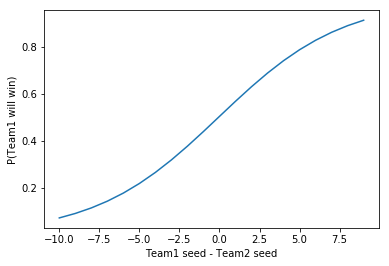

In [31]:
## Plot to confirm intuition that greater positive seed difference indicates higher win probability
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

In [38]:
df_sample_sub.to_csv('test-submission.csv', index=False)